In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import v2
from torchvision.transforms import ToTensor
from torch.nn import functional as F

import os

import numpy as np 

import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
images = []
segmentation_masks = []

for img_name in os.listdir(r'C:\Users\ffedo\Desktop\data_science\data\2_rucode\segm_train\train\images'):
    images.append('C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_train/train/images/' + img_name)

for img_name in os.listdir(r'C:\Users\ffedo\Desktop\data_science\data\2_rucode\segm_train\train\gt'):
    segmentation_masks.append('C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_train/train/gt/' + img_name)

In [4]:
images[:5], segmentation_masks[:5]

(['C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_train/train/images/1.tif',
  'C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_train/train/images/10.tif',
  'C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_train/train/images/100.tif',
  'C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_train/train/images/1000.tif',
  'C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_train/train/images/1001.tif'],
 ['C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_train/train/gt/1.tif',
  'C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_train/train/gt/10.tif',
  'C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_train/train/gt/100.tif',
  'C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_train/train/gt/1000.tif',
  'C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_train/train/gt/1001.tif'])

In [5]:
class CustomDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

        # self.images_transforms = transforms.Compose([
        #     transforms.Resize((256, 256)), # размер каждой картинки будет приведен к 256*256
        #     transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        #     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # значения пикселей картинки нормализуются
        # ])

        # self.masks_transforms = transforms.Compose([
        #     transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # размер каждой картинки будет приведен к 256*256
        #     transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        # ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ind):
        img = ToTensor()(Image.open(self.images[ind]))

        # mask = ToTensor()(Image.open(self.masks[ind])).reshape(1,256,256)

        mask = Image.open(self.masks[ind])
        mask = np.array(mask, dtype=np.bool_)
        mask = ToTensor()(mask).reshape(1,256,256)
         
        #img = self.images_transforms(image)
        #mask = self.masks_transforms(mask)
        
        return img, mask

In [6]:
dataset = CustomDataset(images, segmentation_masks)

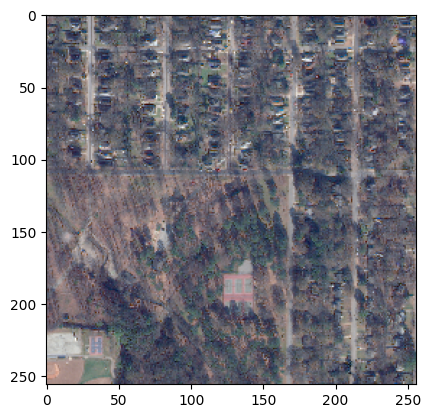

In [7]:
plt.imshow(dataset[0][0].permute(1,2,0))

In [8]:
print(dataset[0][1].shape)
dataset[0][1]

torch.Size([1, 256, 256])


tensor([[[ True,  True,  True,  ...,  True, False, False],
         [False,  True,  True,  ...,  True, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

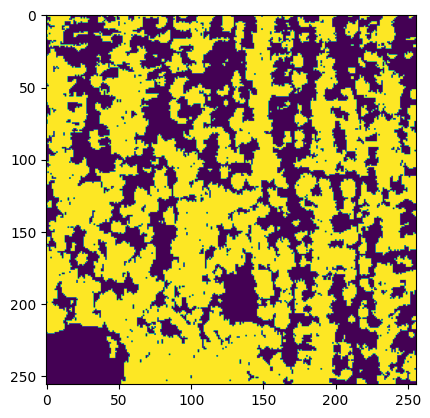

In [9]:
plt.imshow(dataset[0][1].reshape(256,256))

In [10]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64)
train_loader

In [11]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=6, pretrained=False)

Using cache found in C:\Users\ffedo/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [12]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2.*intersection+ self.smooth)/(y_pred.sum()+y_true.sum()+self.smooth)
        return 1. - dsc

In [13]:
def train(model, opt, loss_fn, epochs, data_train):
    torch.cuda.empty_cache()
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for i, (X_batch, Y_batch) in enumerate(tqdm(data_train)):
            # переносим батч на GPU
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            Y_pred = model(X_batch)
            #print(Y_pred.shape,Y_batch.shape)
            # Y_pred = torch.flatten(Y_pred, start_dim=2, end_dim=-1)
            # Y_batch = torch.flatten(Y_batch, start_dim=1, end_dim=-1)
            loss = loss_fn(Y_pred, Y_batch)
            #loss = bce_loss(Y_pred, Y_batch.long())
            loss.backward()  
            opt.step()  
            opt.zero_grad()

            
            avg_loss += loss / len(train_loader)

            # после каждой эпохи будем визуализировать 
            # сегментацию на шести картинках из data_val

            if i%10 == 0:

                # выводим средний лосс на последних пяти обучающих итерациях
                print('avg train loss: %f' % avg_loss)

            avg_loss = 0
    

In [14]:
model = model.to(device)
loss = DiceLoss()
#loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
train(model, opt, loss, 2, train_loader)

* Epoch 1/2


  0%|          | 0/45 [00:00<?, ?it/s]

avg train loss: 0.011471
avg train loss: 0.010951
avg train loss: 0.010123
avg train loss: 0.016663
avg train loss: 0.008902
* Epoch 2/2


  0%|          | 0/45 [00:00<?, ?it/s]

avg train loss: 0.009899
avg train loss: 0.009656
avg train loss: 0.009514
avg train loss: 0.016479
avg train loss: 0.008707


In [15]:
torch.cuda.empty_cache()

In [16]:
with torch.no_grad():
    output = model(dataset[0][0].reshape(1,3,256,256).to(device))

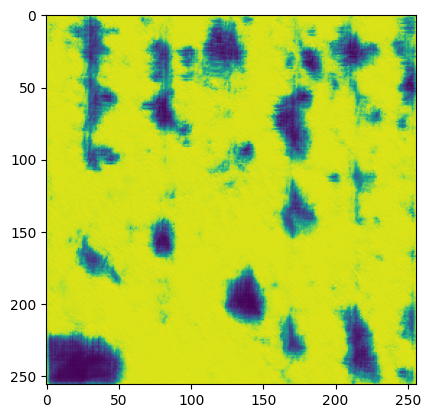

In [17]:
plt.imshow(output.reshape(256,256).cpu())

In [18]:
output

tensor([[[[0.4992, 0.4919, 0.5100,  ..., 0.4873, 0.4896, 0.5257],
          [0.5118, 0.4972, 0.5058,  ..., 0.4527, 0.3959, 0.4339],
          [0.5032, 0.4943, 0.5050,  ..., 0.2703, 0.4062, 0.4319],
          ...,
          [0.4766, 0.3686, 0.1624,  ..., 0.3273, 0.4482, 0.4952],
          [0.5098, 0.3272, 0.2147,  ..., 0.4228, 0.4858, 0.4842],
          [0.5049, 0.4717, 0.3348,  ..., 0.4548, 0.4845, 0.4929]]]],
       device='cuda:0')

In [19]:
class testDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ind):
        img = ToTensor()(Image.open(self.images[ind]))
        
        return img, self.images[ind][86:]

In [20]:
timages=[]
for img_name in os.listdir(r'C:\Users\ffedo\Desktop\data_science\data\2_rucode\segm_public_test\public_test\images'):
    timages.append('C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_public_test/public_test/images/' + img_name)
timages[:5]

['C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_public_test/public_test/images/t1_1.tif',
 'C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_public_test/public_test/images/t1_10.tif',
 'C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_public_test/public_test/images/t1_100.tif',
 'C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_public_test/public_test/images/t1_101.tif',
 'C:/Users/ffedo/Desktop/data_science/data/2_rucode/segm_public_test/public_test/images/t1_102.tif']

In [21]:
tdataset = testDataset(timages)
tdataset[0]

(tensor([[[0.4157, 0.4667, 0.2902,  ..., 0.3412, 0.4275, 0.6549],
          [0.4549, 0.5686, 0.6706,  ..., 0.4431, 0.4863, 0.6667],
          [0.6431, 0.6980, 0.6471,  ..., 0.5333, 0.5490, 0.6824],
          ...,
          [0.4549, 0.4196, 0.4078,  ..., 0.3216, 0.2941, 0.3216],
          [0.4510, 0.4353, 0.3804,  ..., 0.3961, 0.3020, 0.3098],
          [0.4863, 0.4745, 0.3569,  ..., 0.3647, 0.3098, 0.3490]],
 
         [[0.3922, 0.4510, 0.2157,  ..., 0.5176, 0.4471, 0.6549],
          [0.4392, 0.5647, 0.6863,  ..., 0.5137, 0.4941, 0.6745],
          [0.6980, 0.7412, 0.6549,  ..., 0.5255, 0.5451, 0.6902],
          ...,
          [0.4118, 0.3804, 0.4157,  ..., 0.2627, 0.2706, 0.3255],
          [0.4275, 0.4431, 0.4118,  ..., 0.4118, 0.3333, 0.3569],
          [0.4588, 0.4588, 0.3255,  ..., 0.3451, 0.3333, 0.4039]],
 
         [[0.3843, 0.4667, 0.2471,  ..., 0.5216, 0.3373, 0.6196],
          [0.4039, 0.5098, 0.6941,  ..., 0.4196, 0.3882, 0.6353],
          [0.7412, 0.7608, 0.6235,  ...,

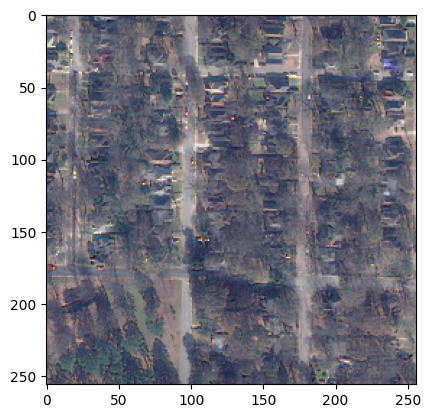

In [22]:
plt.imshow(tdataset[0][0].permute(1,2,0))

In [23]:
predloader = DataLoader(tdataset, batch_size=1)
predloader

In [24]:
model.eval()
lst_ts=[]
with torch.no_grad():
    for X, name in tqdm(predloader):
        X = X.to(device)
        
        Y_pred = model(X).reshape(256,256).detach().cpu().numpy() 
        
        #print(Y_hat.shape)
        lst_ts.append(Y_pred)

        cv2.imwrite('C:/Users/ffedo/Desktop/data_science/peni/'+name[0], Y_pred)

  0%|          | 0/707 [00:00<?, ?it/s]

In [25]:
lst_ts[0].shape

(256, 256)

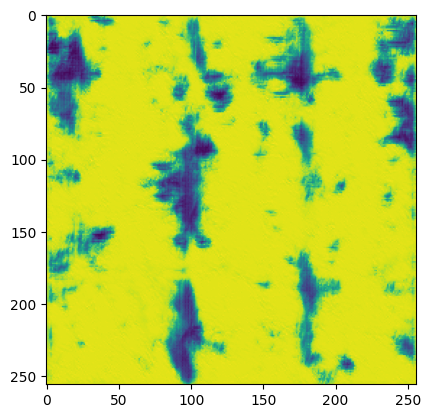

In [26]:
plt.imshow(lst_ts[0])

# создание NPY

In [62]:
# Указать здесь путь до test набора
path_to_dir = 'C:/Users/ffedo/peni'

In [63]:
# Получение списка всех файлов в директории
files = os.listdir(path_to_dir)
len(files)

707

In [55]:
def Z(image_np):
    for y in range(256):
        for x in range(256):
            pixel_color = image_np[y, x]  # Получение цвета пикселя
    
            # Проверка на оттенок зеленого (заданный диапазон оттенков)
            if pixel_color >= 0.5:
                image_np[y, x] = True  # Закрашиваем пиксель белым
            else:
                image_np[y, x] = False # Закрашиваем пиксель черным
    
    return image_np

In [65]:
def read_image_as_tensor(file_path):
    # Чтение изображения с помощью OpenCV
    image = Image.open(file_path)
    # Преобразование в тензор numpy
    tensor = Z(np.array(image))
    return tensor

In [68]:
# Список для хранения тензоров
tensor_list = []

In [69]:
for filename in tqdm(files):
    file_path = os.path.join(path_to_dir, filename)
    tensor = read_image_as_tensor(file_path)
    tensor_list.append(tensor)

  0%|          | 0/707 [00:00<?, ?it/s]

In [71]:
# Преобразование списка тензоров в тензор numpy
tensor_array = np.array(tensor_list, dtype=np.bool_)
tensor_array

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [72]:
# Печать размерности полученного тензора. Проверьте, что количество количество снимков совпадает с количеством полученных тензоров маски
print("Размерность тензора:", tensor_array.shape)

Размерность тензора: (707, 256, 256)


In [73]:
output_file = "C:/Users/ffedo/solution.npy"
# Сохранение тензорного массива в файл .npy
np.save(output_file, tensor_array)